# Example to use Augraphy to augment training images in Tensorflow pipeline

In this example, Augraphy will be used to perform augmentation in a a Tensorflow image classification model. Transfer learning is applied on Resnet to further fine tune the model to classify between "dirty" and "clean" document images.The image data is a smaller subset of a document denoising competition dataset: [Denoising ShabbyPages](https://www.kaggle.com/competitions/denoising-shabby-pages).

In [ ]:
# download and unzip document image data

!gdown --id 1uJPavzL7K3FFr9MEfZbdX3SNa1bGEdPu

!unzip shabby_small.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1uJPavzL7K3FFr9MEfZbdX3SNa1bGEdPu
To: /content/shabby_small.zip
100% 61.1M/61.1M [00:00<00:00, 122MB/s]
Archive:  shabby_small.zip
   creating: shabby_small/
   creating: shabby_small/test/
   creating: shabby_small/test/test_clean/
   creating: shabby_small/test/test_clean/clean/
  inflating: shabby_small/test/test_clean/clean/0004-State-2021_How-to-Password-Protect-PDF-Documents.pdf-2.png  
  inflating: shabby_small/test/test_clean/clean/0005-IRS-irs-pdf_i1120f.pdf-09.png  
  inflating: shabby_small/test/test_clean/clean/0007-Census-hsv_currenthvspress.pdf-05.png  
  inflating: shabby_small/test/test_clean/clean/0008-FederalReserve-pressreleases_bcreg20200304a3.pdf-23.png  
  inflating: shabby_small/test/test_clean/clean

In [ ]:
# Install  Augraphy, the main image augmentation library

!pip install git+https://github.com/sparkfish/augraphy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/sparkfish/augraphy to /tmp/pip-req-build-3cf2rkcl
  Running command git clone --filter=blob:none --quiet https://github.com/sparkfish/augraphy /tmp/pip-req-build-3cf2rkcl
  Resolved https://github.com/sparkfish/augraphy to commit 978206e8f77856e9fb94c0fc9b08087b72805abc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for augraphy: filename=augraphy-8.2.3-py3-none-any.whl size=123541 sha256=ddba4d92231e7b16d722dbc6de0c0850a6c2fe909599abb253b955073ad94986
  Stored in directory: /tmp/pip-ephem-wheel-cache-cz8z3r3u/wheels/36/d0/21/1aa9ab43fc6934decc10b8a3b839a472b0fed7d3d185b90d51
Successfully built augraphy


In [ ]:
# import libraries

import sys
import glob
import cv2
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, Model
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping

from tqdm import tqdm


from matplotlib import pyplot as plt
from time import time

AUTOTUNE = tf.data.AUTOTUNE


In [ ]:
# create an Augraphy augmentation pipeline

from augraphy import *

ink_phase = [Dithering(p=0.5),
             InkBleed(p=0.5),
             OneOf([LowInkRandomLines(p=1), LowInkPeriodicLines(p=1)]),
            ]

paper_phase = [ColorPaper(p=0.5)]

post_phase = [Markup(p=0.25),
              DirtyRollers(p=0.25),
              Scribbles(p=0.25),
              BindingsAndFasteners(p=0.25),
              BadPhotoCopy(p=0.25),
              DirtyDrum(p=0.25),
              ]

augmentation_pipeline = AugraphyPipeline(ink_phase, paper_phase, post_phase)


In [ ]:
# training parameters

batch_size = 32
epochs = 60
shuffle= 0
image_size = 400
  

In [ ]:
# define data

dirty_train_path = "/content/shabby_small/train/train_dirty/dirty/"
clean_train_path = "/content/shabby_small/train/train_clean/clean/"

dirty_validate_path = "/content/shabby_small/validate/validate_dirty/dirty/"
clean_validate_path = "/content/shabby_small/validate/validate_clean/clean/"

dirty_test_path = "/content/shabby_small/test/test_dirty/dirty/"
clean_test_path = "/content/shabby_small/test/test_clean/clean/"

train_files = glob.glob(clean_train_path+"/*.png")
validate_files = glob.glob(clean_validate_path+"/*.png")
test_files = glob.glob(clean_test_path+"/*.png")

In [ ]:
# create datasets

def read_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    # image = tf.image.rgb_to_grayscale(image)
    image = tf.image.resize(image, (image_size, image_size))
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image.set_shape((image_size, image_size, 3))
    return image, label

def augment_image(image, label):
    image_single = tf.reshape(image, [image_size, image_size, 3])
    augmented_image  = image_single.numpy()
    augmented_image = augmentation_pipeline(augmented_image)
    if len(augmented_image.shape)<3:
        augmented_image = tf.image.rgb_to_grayscale(augmented_image)
    augmented_image = tf.cast(augmented_image, tf.float32)
    augmented_image.set_shape((image_size, image_size, 3))
    return augmented_image, label

# initialize dataset from path
train_dataset = tf.data.Dataset.from_tensor_slices(train_files)
validate_dataset = tf.data.Dataset.from_tensor_slices(validate_files)
test_dataset = tf.data.Dataset.from_tensor_slices(test_files)

# create dataset from training data and labels
labels_clean = tf.cast(np.array([0 for _ in range(len(train_files))]), tf.float32)
labels_dirty = tf.cast(np.array([1 for _ in range(len(train_files))]), tf.float32)
train_dataset_clean = tf.data.Dataset.from_tensor_slices((train_files,labels_clean))
train_dataset_dirty = tf.data.Dataset.from_tensor_slices((train_files,labels_dirty))

labels_clean = tf.cast(np.array([0 for _ in range(len(validate_files))]), tf.float32)
labels_dirty = tf.cast(np.array([1 for _ in range(len(validate_files))]), tf.float32)
validate_dataset_clean = tf.data.Dataset.from_tensor_slices((validate_files,labels_clean))
validate_dataset_dirty = tf.data.Dataset.from_tensor_slices((validate_files,labels_dirty))

labels_clean = tf.cast(np.array([0 for _ in range(len(test_files))]), tf.float32)
labels_dirty = tf.cast(np.array([1 for _ in range(len(test_files))]), tf.float32)
test_dataset_clean = tf.data.Dataset.from_tensor_slices((test_files,labels_clean))
test_dataset_dirty = tf.data.Dataset.from_tensor_slices((test_files,labels_dirty))


# add preprocessing and augmentation functions into dataset
train_images_clean = (train_dataset_clean.shuffle(len(train_files), seed=42)
                      .map(read_image, num_parallel_calls=AUTOTUNE)
                      .cache()
                      .batch(batch_size)
                      .prefetch(AUTOTUNE)
                      )
train_images_dirty = (train_dataset_dirty
                      .shuffle(len(train_files), seed=42)
                      .map(read_image, num_parallel_calls=AUTOTUNE)
                      .map(lambda x, y: tf.py_function(augment_image, [x, y], [tf.float32,tf.float32]))
                      .map(lambda x, y: [tf.ensure_shape(x, (image_size, image_size, 3)), tf.ensure_shape(y, ()) ]   ) 
                      .cache()
                      .batch(batch_size)
                      .prefetch(AUTOTUNE)
                      )

validate_images_clean = (validate_dataset_clean.shuffle(len(validate_files), seed=42)
                        .map(read_image, num_parallel_calls=AUTOTUNE)
                        .cache()
                        .batch(batch_size)
                        .prefetch(AUTOTUNE)
                        )
validate_images_dirty = (validate_dataset_dirty
                        .shuffle(len(validate_files), seed=42)
                        .map(read_image, num_parallel_calls=AUTOTUNE)
                        .map(lambda x, y: tf.py_function(augment_image, [x, y], [tf.float32,tf.float32]))
                        .map(lambda x, y: [tf.ensure_shape(x, (image_size, image_size, 3)), tf.ensure_shape(y, ()) ]   ) 
                        .cache()
                        .batch(batch_size)
                        .prefetch(AUTOTUNE)
                        )

test_images_clean = (test_dataset_clean.shuffle(len(test_files), seed=42)
                    .map(read_image, num_parallel_calls=AUTOTUNE)
                    .cache()
                    .batch(1)
                    .prefetch(AUTOTUNE)
                    )
test_images_dirty = (test_dataset_dirty
                    .shuffle(len(test_files), seed=42)
                    .map(read_image, num_parallel_calls=AUTOTUNE)
                    .map(lambda x, y: tf.py_function(augment_image, [x, y], [tf.float32,tf.float32]))
                    .map(lambda x, y: [tf.ensure_shape(x, (image_size, image_size, 3)), tf.ensure_shape(y, ()) ]   ) 
                    .cache()
                    .batch(1)
                    .prefetch(AUTOTUNE)
                    )

# merge dirty and clean, create the final datasets
train_images = train_images_clean.concatenate(train_images_dirty)
validate_images = validate_images_clean.concatenate(validate_images_dirty)
test_images = test_images_clean.concatenate(test_images_dirty)

In [ ]:
# print and check each dataset size

print(train_images)
print(validate_images)
print(test_images)

<_ConcatenateDataset element_spec=(TensorSpec(shape=(None, 400, 400, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>
<_ConcatenateDataset element_spec=(TensorSpec(shape=(None, 400, 400, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>
<_ConcatenateDataset element_spec=(TensorSpec(shape=(None, 400, 400, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


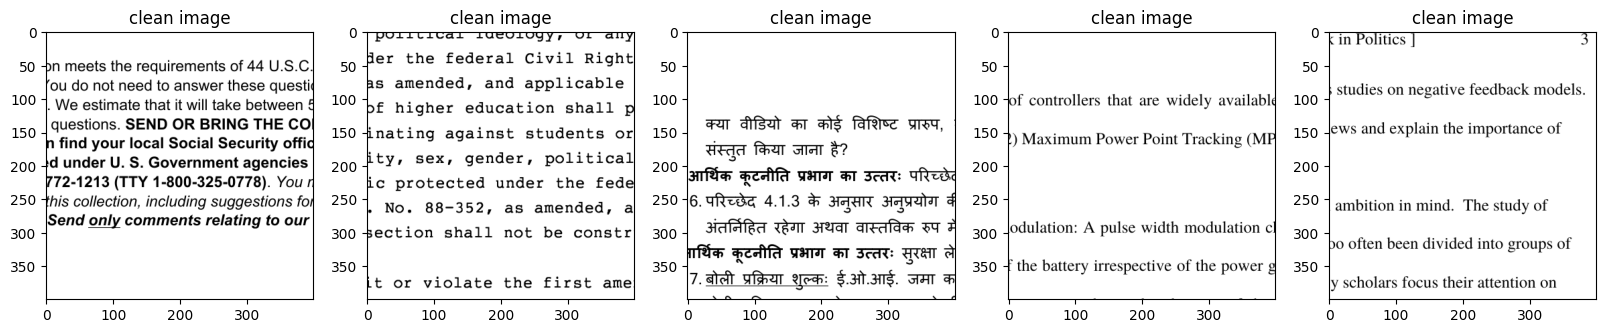

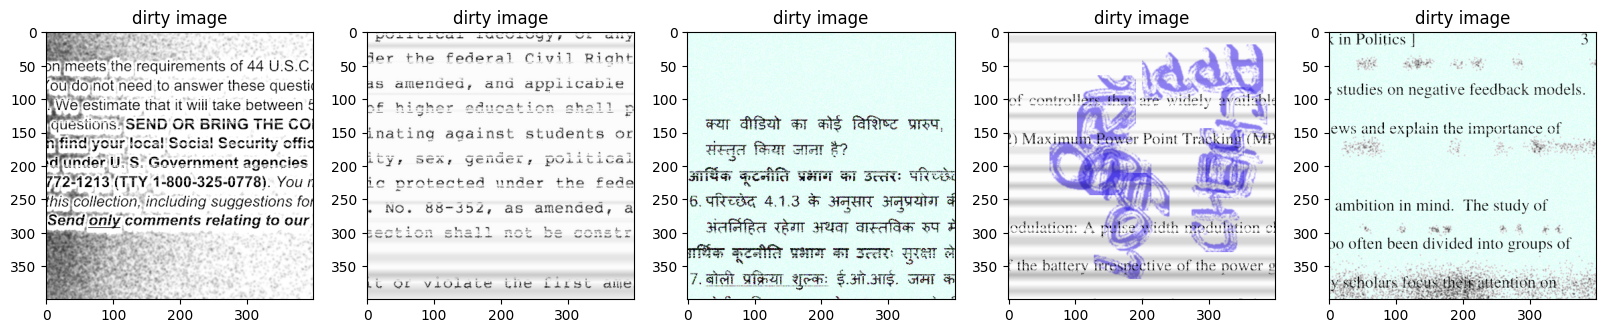

In [ ]:
# display some of the training images

plt.rcParams["figure.figsize"] = (20,20)
# clean
for image in train_images:
    plt.figure()
    for i in range(image[0].shape[0]): 
        plt.subplot(1,5,i+1)
        plt.imshow(image[0][i]/255, cmap="gray")
        plt.title("clean image")
        if i>=4:
            break
    break
# dirty
for image in train_images:
    if image[1][0] == 1:
        plt.figure()
        for i in range(image[0].shape[0]): 
            plt.subplot(1,5,i+1)
            plt.imshow(image[0][i]/255, cmap="gray")
            plt.title("dirty image")
            if i>=4:
                break
        break

In [ ]:
# transfer learning using resnet

pretrained_model = tf.keras.applications.ResNet152(weights = 'imagenet', include_top = False, input_shape = (400,400,3))

for layer in pretrained_model.layers:
    layer.trainable = False

x = layers.Flatten()(pretrained_model.output)
x = layers.Dense(1000, activation='relu')(x)
predictions = layers.Dense(1, activation = 'sigmoid')(x)

model = Model(inputs = pretrained_model.input, outputs = predictions)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics = ['accuracy'])



234698864/234698864 [==============================] - 1s 0us/step


In [ ]:
# train model
callback = EarlyStopping(monitor='val_loss', patience=10)
train_history = model.fit(train_images, validation_data = validate_images, epochs=epochs, callbacks=[callback], verbose=1)

Epoch 1/60
42/42 [==============================] - 316s 7s/step - loss: 99.2728 - accuracy: 0.8115 - val_loss: 21.5744 - val_accuracy: 0.5000
Epoch 2/60
42/42 [==============================] - 44s 1s/step - loss: 10.6968 - accuracy: 0.1557 - val_loss: 0.6909 - val_accuracy: 0.5103
Epoch 3/60
42/42 [==============================] - 43s 1s/step - loss: 0.6918 - accuracy: 0.5061 - val_loss: 0.6900 - val_accuracy: 0.5172
Epoch 4/60
42/42 [==============================] - 51s 1s/step - loss: 0.6876 - accuracy: 0.5198 - val_loss: 0.6769 - val_accuracy: 0.5466
Epoch 5/60
42/42 [==============================] - 44s 1s/step - loss: 0.6712 - accuracy: 0.5534 - val_loss: 0.6422 - val_accuracy: 0.6052
Epoch 6/60
42/42 [==============================] - 44s 1s/step - loss: 0.6121 - accuracy: 0.6748 - val_loss: 0.5529 - val_accuracy: 0.7690
Epoch 7/60
42/42 [==============================] - 44s 1s/step - loss: 0.4841 - accuracy: 0.8626 - val_loss: 0.4853 - val_accuracy: 0.8793
Epoch 8/60
42/42

(0.0, 1.0)

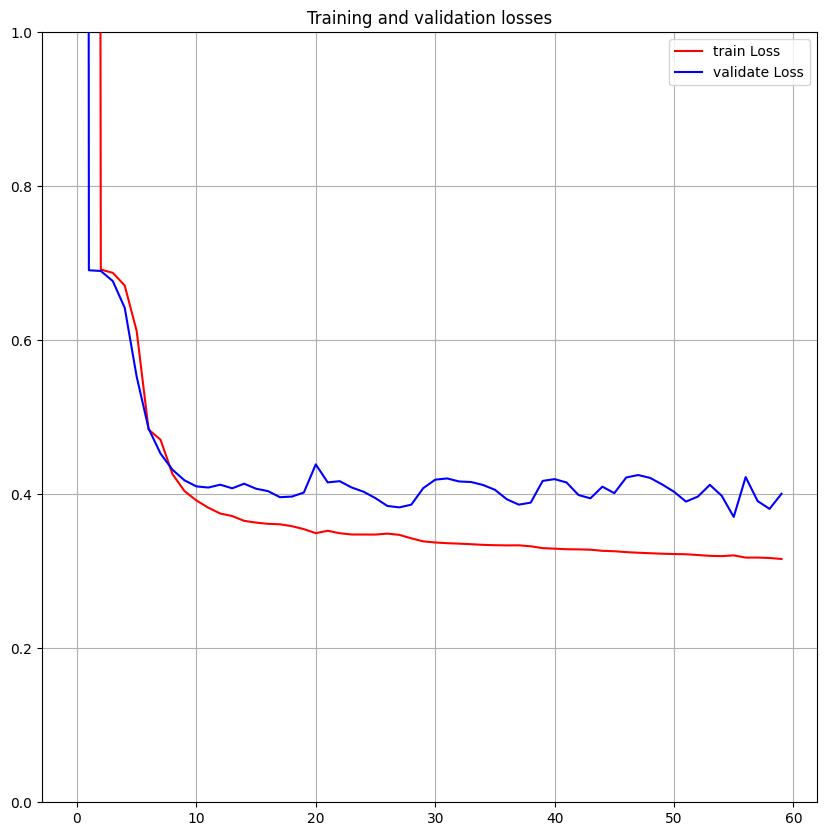

In [ ]:
# plot training curve

plt.rcParams["figure.figsize"] = (10,10)
train_losses = train_history.history['loss']
validate_losses = train_history.history['val_loss']
accuracy = train_history.history['accuracy']

x_train = [i for i in range(len(train_losses))]
x_validate = [i for i in range(len(validate_losses))]

plt.figure()
plt.grid()
plt.plot(x_train, train_losses, "red", label='train Loss')
plt.plot(x_validate, validate_losses, "blue", label='validate Loss')
plt.title("Training and validation losses")
plt.legend(loc="upper right")
plt.ylim(0, 1)

In [ ]:
# predict testing images

predicted_labels = model.predict(test_images)

372/372 [==============================] - 17s 44ms/step


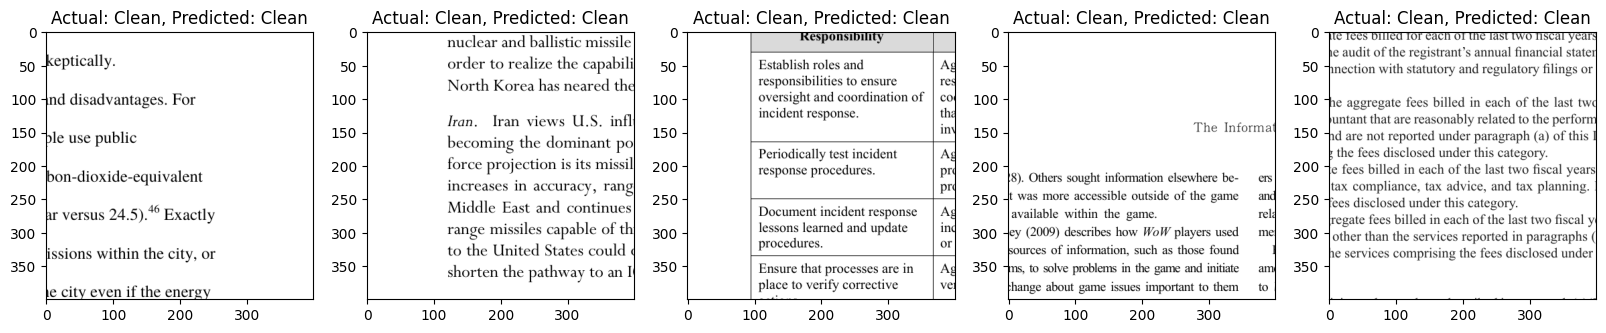

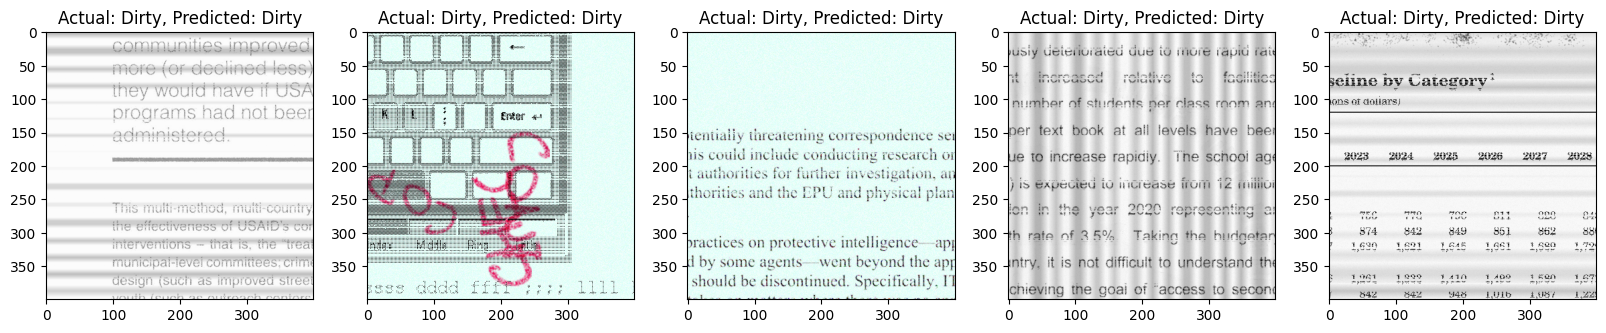

In [ ]:
# Display predicted results

plt.rcParams["figure.figsize"] = (20,20)
n_clean = 0
plt.figure()
for i, image in enumerate(test_images):
    if image[1] == 0:
        n_clean += 1
        plt.subplot(1,5,n_clean)
        plt.imshow(image[0][0]/255)
        if predicted_labels[i] < 0.5:
            predicted_label = "Clean"
        else:
            predicted_label = "Dirty"
        plt.title("Actual: Clean, Predicted: "+predicted_label)
        if n_clean >=5:
            break
    
plt.figure()
n_dirty = 0
for i, image in enumerate(test_images):
    if image[1] == 1:
        n_dirty += 1
        plt.subplot(1,5,n_dirty)
        plt.imshow(image[0][0]/255)
        if predicted_labels[i] < 0.5:
            predicted_label = "Clean"
        else:
            predicted_label = "Dirty"
        plt.title("Actual: Dirty, Predicted: "+predicted_label)
        if n_dirty >=5:
            break
